In [1]:
# change working directory to the project root
import os
os.chdir('../../')

import sys
sys.path.append('models/utils')
sys.path.append('models/brian2')
sys.path.append('models/aln')

In [2]:
# aln-imports
import defaultParameters as dp
import fitparams as fp
import aEIF_extended as IF_Models

# python-imports
#% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

In [14]:
params = dp.loadDefaultParams(singleNode=1)

#  Calculate and plot effective electrical field input

In [4]:
EIFNeuron = IF_Models.EIFModel()

# DEFAULT VALUES
# check if BS parameters C and gL match with the AdEx parameters
print("aEIF C: {}".format(params['C']*1e-12))
print("aEIF gL: {}".format(params['gL']*1e-9))

#EIFNeuron.C_soma     = 1.0e-2  # Soma membrane capacitance (F / m2)
#EIFNeuron.rhom_soma  = 28.0e-1  # Soma membrane resistivity (Ohm m2)
#EIFNeuron.d_soma     = 10e-6   # Soma diameter ( m )

EIFNeuron.d_dend      = 2.0e-6  # Dendritic tree diameter (m)
EIFNeuron.L           = 1200.0e-6  # Dendritic tree length (m)

EIFNeuron.updateParams()

print("BS C: {}".format(EIFNeuron.C_s))
print("BS gL: {}".format(EIFNeuron.gL))

EIFNeuron.polarizationTransfer

aEIF C: 2e-10
aEIF gL: 1e-08
BS C: 3.141592653589794e-12
BS gL: 1.1219973762820692e-10


<bound method IFModel.polarizationTransfer of <aEIF_extended.EIFModel object at 0x12be0eac8>>

In [5]:
def current_for_adex(freq, EIFNeuron):
    # impedance
    z_adex = params['gL']*1e-9 * (1-1 * np.exp((-70-params['VT'])/params['DeltaT'])) + params['C']*1e-12 * 1j* 2*np.pi * freq
    z_bs = EIFNeuron.gL * (1 - 1 * np.exp((-65e-3-EIFNeuron.VT)/EIFNeuron.deltaT)) +  EIFNeuron.C_s * 1j* 2*np.pi * freq

    current = z_adex * EIFNeuron.polarizationTransfer(freq)
    return np.abs(current)

freq = 30
print("{} pA".format(current_for_adex(freq, EIFNeuron)*1e12))

15.750992700495186 pA


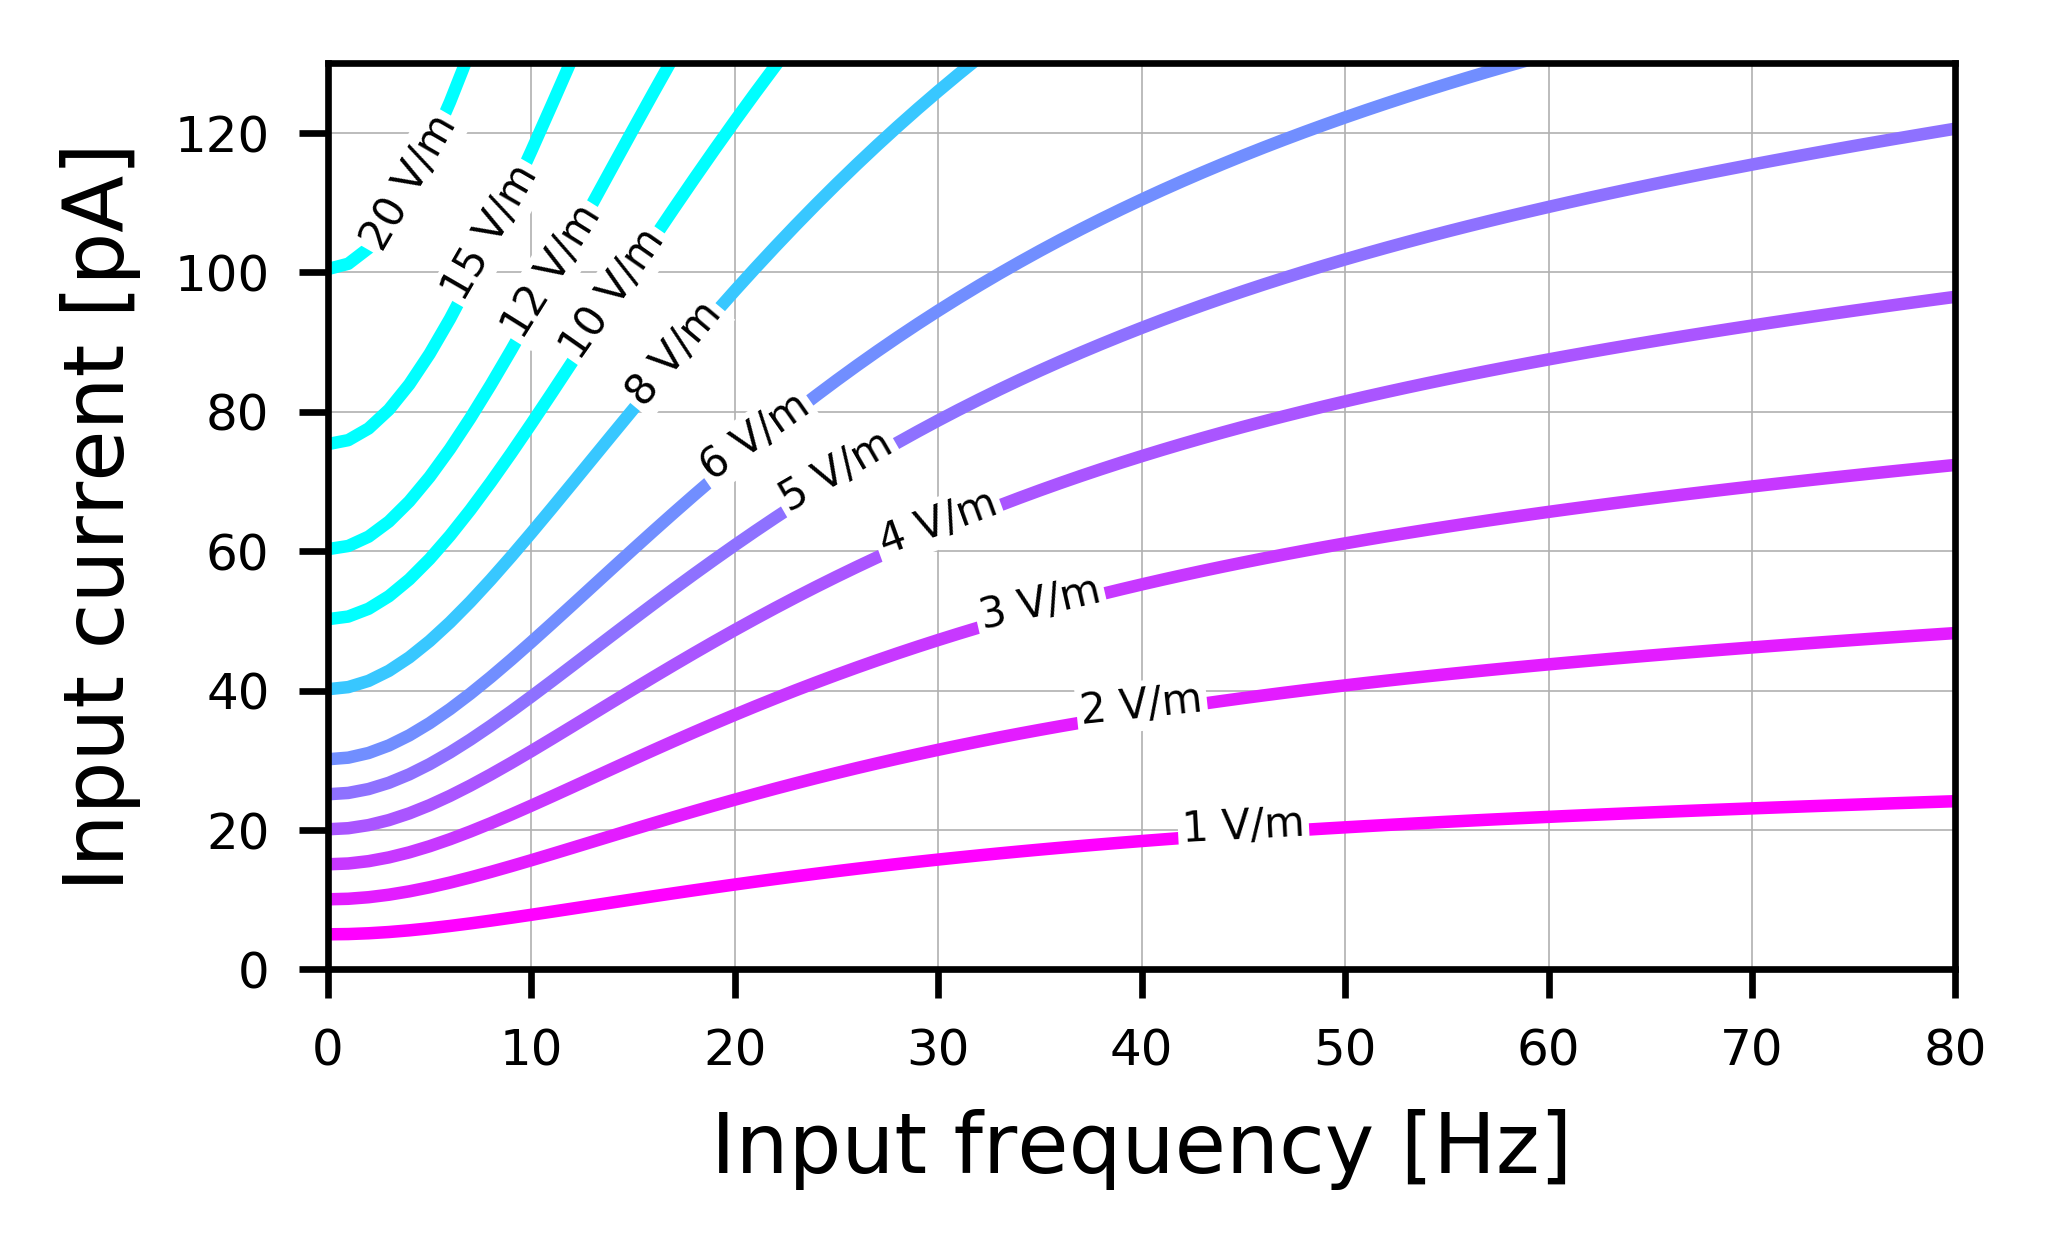

In [11]:
plt.figure(figsize=(3.5, 2.0), dpi=600)
maxfr = 100
freqs = np.linspace(0, maxfr, maxfr+1)
amps = []
for f in freqs:
    amps.append(current_for_adex(f, EIFNeuron)*1e12)

cmap = plt.cm.cool_r
norm = matplotlib.colors.Normalize(vmin=1, vmax=10)
def c(c): return cmap(norm(c))

col = 'k'
for amp in [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20]:
    plt.plot(freqs, np.multiply(amps,amp), c=c(amp), label='{} V/m'.format(amp))

plt.ylim(0, 130)
plt.xlim(0, 80)
#plt.hlines(0.2, 0, maxfr, color='k', linestyle='--')
#plt.hlines(0.4, 0, maxfr, color='k', linestyle='--')
plt.grid(linewidth=0.2)
plt.locator_params(axis='x', nbins=10)
plt.locator_params(axis='y', nbins=10)

plt.tick_params(axis='both', which='major', labelsize=6)

plt.xlabel("Input frequency [Hz]")
plt.ylabel("Input current [pA]")

col = 'k'
fs = 6.5

import scipy.misc

for i, amp in enumerate([1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20]):
    freq_x = (10-amp)*4+2
    
    plotfreqs = [4, 8, 11, 14, 17, 21, 25, 30, 35, 40, 45][::-1]
    freq_x = plotfreqs[i] 
    
    amp_val = np.multiply(amps,amp)[freq_x] + 1
    
    rot = 1/scipy.misc.derivative(lambda amp: np.multiply(amps,amp)[freq_x], freq_x)  * 200
    
    rots = [3, 6, 13, 20, 30, 35, 50, 55, 58, 60, 60]
    rot = rots[i]    
    
    bbox_props = dict(fc="w", ec="white", pad=0.0, alpha=1.0)
    plt.text(freq_x, amp_val,  '{} V/m'.format(amp), fontsize=5, color=col, bbox=bbox_props, rotation=rot, ha='center', va='center')

#plt.savefig("tACS_equiv_current.png")
#plt.savefig("tACS_equiv_current.svg")
plt.savefig("figures/equivalent_electric_field.png")
plt.savefig("figures/equivalent_electric_field.png")

# Inverse problem

Text(0, 0.5, 'E-Field [V/m]')

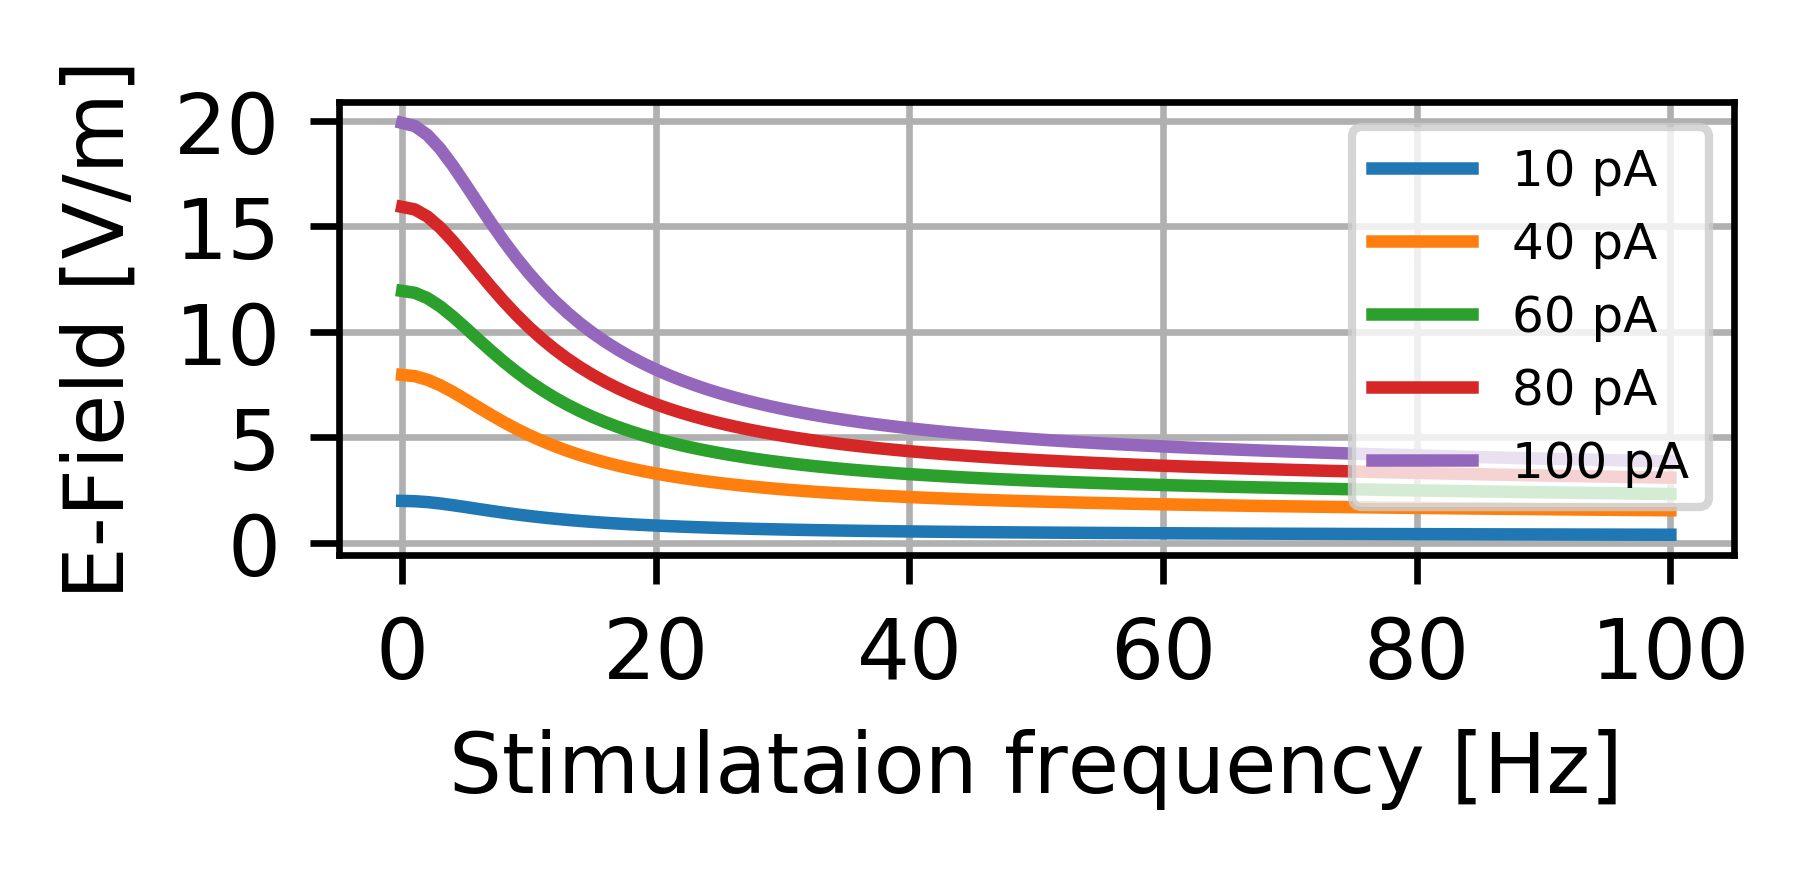

In [12]:
# invert problem by brute force:


def find_efield_amp(freq, current_amp):
    # current_amp: amplitude of current in pA that you want to convert to field
    # freq: the frequency of the oscillation
    return current_amp/(current_for_adex(freq, EIFNeuron)*1e12)

amps = [10, 40, 60, 80, 100]
freqs = np.linspace(0, 100, 101)
field_amps = []
plt.figure(figsize=(3, 1), dpi=600)
for amp in amps:
    field_amps = []
    for freq in freqs:
        field_amp = find_efield_amp(freq, amp)
        field_amps.append(field_amp)
        #print(amp, field_amp)
    
    plt.plot(freqs, field_amps, label="{} pA".format(amp))

plt.locator_params(axis='y', nbins=6)    
plt.locator_params(axis='x', nbins=8)    


plt.grid()
plt.legend(loc=1, prop={'size': 6})
plt.xlabel("Stimulataion frequency [Hz]")
plt.ylabel("E-Field [V/m]")